# Importing the Libraries

In [1]:
!pip install torchmetrics
!pip install pytorch_lightning


import os
import io
import csv
import torch
import random
import zipfile
import warnings
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torchvision.models
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pytorch_lightning as pl


from PIL import Image
from torchvision import transforms
from torchvision.transforms import v2
from torchmetrics.functional import accuracy
from sklearn.metrics import confusion_matrix
from torchvision.datasets import VisionDataset
from pytorch_lightning.loggers import CSVLogger
from torch.utils.data import Dataset, random_split, DataLoader, default_collate
from pytorch_lightning import LightningDataModule, LightningModule, seed_everything, Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar, ModelCheckpoint

from google.colab import drive
drive.mount('/content/drive')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

# The Data

In [2]:
original_zip_file_path  = "/content/drive/MyDrive/My projects/One Piece CNN/One Piece dataset.zip"
new_zip_file_path = "/content/drive/MyDrive/My projects/One Piece CNN/One Piece dataset clean.zip"


names_to_delete = ["inverted", "modified", "rotated", "Edited", "Rotated"]

with zipfile.ZipFile(original_zip_file_path, 'r') as original_zip, zipfile.ZipFile(new_zip_file_path, 'w') as new_zip:
    for file_info in original_zip.infolist():
        if not any(name in file_info.filename for name in names_to_delete):
            with original_zip.open(file_info) as source, new_zip.open(file_info.filename, 'w') as target:
                target.write(source.read())

os.remove(original_zip_file_path)
os.rename(new_zip_file_path, original_zip_file_path)


In this cell I clean the zip file by removing all undesired images.

In this case I noticed the original file presented augmented images, but I want to do my own image augmentation later on.

The way this is done is by creating a new file that contains only the desired images and let it take the place of the original one.

In [3]:
seed_everything(69)

torch.set_float32_matmul_precision('high')

AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
PATH_OUTPUT = "/content/drive/MyDrive/My projects/One Piece CNN/"


INFO:lightning_fabric.utilities.seed:Seed set to 69


Here I set up some varibles that will be needed later on.

In [4]:
one_piece_zip = '/content/drive/MyDrive/My projects/One Piece CNN/One Piece dataset.zip'
classes_names = 'classnames.txt'


with zipfile.ZipFile(one_piece_zip, 'r') as zip_ref:
    with zip_ref.open(classes_names) as file:
        content = file.read().decode('utf-8')

class_mapping = {}
names = content.split('\n')

for i in range(len(names)):
    names[i] = names[i].strip()

for index, name in enumerate(names, start=0):
    class_mapping[name] = index


Here I create a dictionary matching the names of the One Piece characters with numbers, to have an easy translator between what the model works with and what my eyes see.

In [5]:
class OP_Dataset(VisionDataset):
    def __init__(self, zip_file, class_map, transform=None):
        super().__init__(None, transform=transform)
        self.zip_file = zip_file
        self.file_list = self._get_file_list()
        self.class_map = class_map
        self.classes = sorted(set(self.class_map.values()))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    def _get_file_list(self):
        # taking the images from the zip file without extracting it
        file_list = []
        with zipfile.ZipFile(self.zip_file, 'r') as z:
            for file_info in z.filelist:
                if file_info.filename.startswith('Data/Data/'):
                    file_list.append(file_info.filename)
        return file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # creating the elements of the dataset
        # image is taken from the list of images
        # label is taken from the path to get to the image (where there is the folder name which is mapped by the dictionary)
        with zipfile.ZipFile(self.zip_file, 'r') as z:
            with z.open(self.file_list[idx]) as file:
                img_data = file.read()
                img = Image.open(io.BytesIO(img_data)).convert("RGB")

        folder_name = self.file_list[idx].split('/')[2]
        label = self.class_map[folder_name]

        if self.transform:
            img = self.transform(img)

        return img, label

# actually creating the dataset
OP = OP_Dataset('/content/drive/MyDrive/My projects/One Piece CNN/One Piece dataset.zip', class_mapping)
print(len(OP))


3765


Here the dataset is generated. Each element is composed of an image and a label, indicating to which class it belongs. The label system has been done using the previously created dictionary.

All code is done tso that the zip file is not extracted, to save up space.

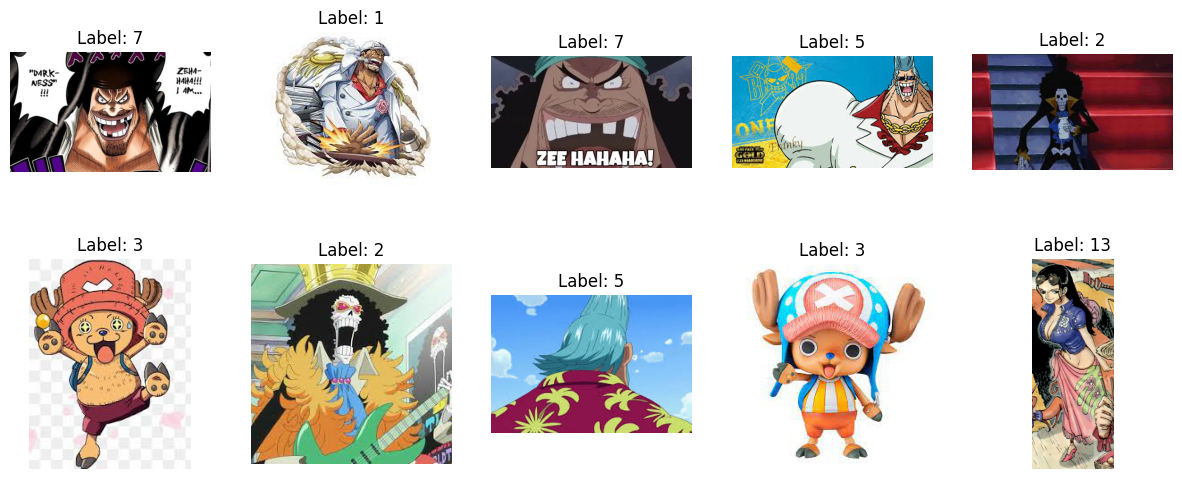

In [9]:
num_images_to_display = 10

random_indices = random.sample(range(len(OP)), num_images_to_display)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    img, label = OP[idx]

    axes[i].imshow(img)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.show()


Here I display 10 random images with their label form the dataset.

In [10]:
class CustomDataModule(LightningDataModule):

    def __init__(self,
                 zip_file: str,
                 batch_size: int,
                 label_map: dict,
                 train_transforms=None,
                 val_transforms=None,
                 test_transforms=None,
                 cutmix_or_mixup=None):

        super().__init__()
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        self.zip_file = zip_file
        self.label_map = label_map
        self.batch_size = batch_size
        self.train_transform = train_transforms
        self.val_transform = val_transforms
        self.test_transform = test_transforms
        self.cutmix_or_mixup = cutmix_or_mixup


    def prepare_data(self):
        # here it goes anything about data preprocessing, download, or anything that
        # comes before the creation of the dataset, or might be useful in the process
        None

    def setup(self, stage=None):
        # setting up the train, val, and test datasets

        self.dataset = OP_Dataset(self.zip_file, self.label_map)

        train_size = int(0.8 * len(self.dataset))
        val_size = (len(self.dataset) - train_size)//2
        test_size = len(self.dataset) - train_size - val_size


        train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
            self.dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

        train_dataset.dataset.transform = self.train_transform
        val_dataset.dataset.transform = self.val_transform
        test_dataset.dataset.transform = self.test_transform

        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset


    def train_dataloader(self):

        def collate_fn(batch):
            # with this function the cutmix or mixup method is applied to the batches of the trainloader
            return self.cutmix_or_mixup(*default_collate(batch))

        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=NUM_WORKERS,
                          collate_fn=collate_fn)


    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=NUM_WORKERS)


    def test_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=NUM_WORKERS)


    def predict_dataloader(self):
        raise NotImplementedError


Here I use the pytorch lightning data module to clearly define how the dataloaders are made.

In [11]:
num_classes = len(names)

train_transform = v2.Compose([
    v2.Resize((224, 224), antialias=True),
    v2.TrivialAugmentWide(),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.RandomErasing(p=0.5, scale=(0.02, 0.23), ratio=(0.3, 3.3)),
])

val_test_transform = v2.Compose([
    v2.Resize((240, 240), antialias=True),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

cutmix = v2.CutMix(alpha=1.0, num_classes=num_classes)
mixup = v2.MixUp(alpha=0.2, num_classes=num_classes)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])


dataModule = CustomDataModule(
    zip_file = one_piece_zip,
    batch_size = BATCH_SIZE,
    label_map =  class_mapping,
    train_transforms = train_transform,
    val_transforms = val_test_transform,
    test_transforms = val_test_transform,
    cutmix_or_mixup = cutmix_or_mixup
)


Here I define the transformations for each dataloader and the actually create them. Validation and test share the same transformations.

# The Process

In [12]:
def create_model():

    model = torchvision.models.efficientnet_v2_m(weights=torchvision.models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)

    return model


This function imports the model that I will use, which is efficientnet with pretrained weights, where the last linear layer leaves the place to a layer with the right number of labels.

In [13]:
class CustomLightning(LightningModule):

    def __init__(self, lr, label_smoothing, lr_warmup_epochs, lr_warmup_decay,
                   norm_weight_decay, weight_decay):
        super().__init__()

        self.save_hyperparameters()
        self.model = create_model()

    def forward(self, x):
        return self.model(x)

    def evaluate(self, batch, stage=None):
        # this is the process to predict an image
        images, target = batch
        output = self.model(images)
        loss = F.cross_entropy(output, target, label_smoothing=self.hparams.label_smoothing)
        preds = torch.argmax(output, dim=1)

        if target.ndim == 2:
            target = target.max(dim=1)[1]
        acc = accuracy(preds, target, num_classes=num_classes, task="multiclass")

        if stage:
            self.log(f'{stage}_loss', loss, prog_bar=True)
            self.log(f'{stage}_acc', acc, prog_bar=True, on_step=False, on_epoch=True, logger=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self.evaluate(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self.evaluate(batch, 'val')

    def test_step(self, batch, batch_idx):
        return self.evaluate(batch, 'test')

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        raise NotImplementedError

    def configure_optimizers(self):
        norm_layer_params = []
        other_layer_params = []

        for name, param in model.named_parameters():
            if 'norm' in name:
                norm_layer_params.append(param)
            else:
                other_layer_params.append(param)

        # Creating optimizer for normalization layers and other layers
        optimizer = torch.optim.AdamW([
            {'params': norm_layer_params, 'weight_decay': self.hparams.norm_weight_decay},
            {'params': other_layer_params, 'weight_decay': self.hparams.weight_decay}],
            lr=self.hparams.lr
        )

        # this is to regulate the lr during the warmup phase
        warmup_lr_scheduler = torch.optim.lr_scheduler.ConstantLR(
            optimizer, factor=self.hparams.lr_warmup_decay, total_iters=self.hparams.lr_warmup_epochs
        )

        # this is to regulate the lr during the main phase
        main_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.trainer.max_epochs-self.hparams.lr_warmup_epochs, eta_min=0.0
        )

        # this is to regulate the lr during the whole process
        lr_scheduler = torch.optim.lr_scheduler.SequentialLR(
            optimizer, schedulers=[warmup_lr_scheduler, main_lr_scheduler], milestones=[self.hparams.lr_warmup_epochs]
        )

        scheduler_dict = {
            'scheduler': lr_scheduler,
            'interval': 'epoch',
        }
        return {'optimizer': optimizer, 'lr_scheduler': scheduler_dict}


Here I use the pytorch lightning module to clearly define the training/testing process of the model.

The loss is computed with categorical crossentropy with label smoothing.

The optimizer is Adam optimizer with weight decay, differentiating between normalization layers and other layers.
The learning rate scheduler adjusts learning rate first in some warm up epochs and then using cosine annealing in the main phase.

In [14]:
# creating a model that executes the gradient descent
model = CustomLightning(
    lr=0.0001,
    lr_warmup_epochs=5,
    lr_warmup_decay=0.01,
    label_smoothing=0.001,
    norm_weight_decay=0.0,
    weight_decay=0.0001,
)

# defining the training/testing process
trainer = Trainer(
    max_epochs= 80,
    accelerator="gpu",
    devices=1,
    logger=CSVLogger(save_dir=PATH_OUTPUT),
    callbacks=[
        LearningRateMonitor(logging_interval="epoch"),
        TQDMProgressBar(refresh_rate=15),
        ModelCheckpoint(dirpath=PATH_OUTPUT, save_top_k=1, monitor="val_acc", mode="max", filename='{epoch}-{train_acc:.3f}-{val_acc:.3f}'),
        ModelCheckpoint(dirpath=PATH_OUTPUT, save_top_k=1, monitor="val_loss", mode="min", filename='{epoch}-{train_loss:.3f}-{val_loss:.3f}')
    ]
)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:01<00:00, 152MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Here the final model including gradient descent, and the training/test process are defined.

In [ ]:
warnings.filterwarnings("ignore")
trainer.fit(model, dataModule)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 52.9 M
---------------------------------------
52.9 M    Trainable params
0         Non-trainable params
52.9 M    Total params
211.526   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=80` reached.


Training the model.

# The Results

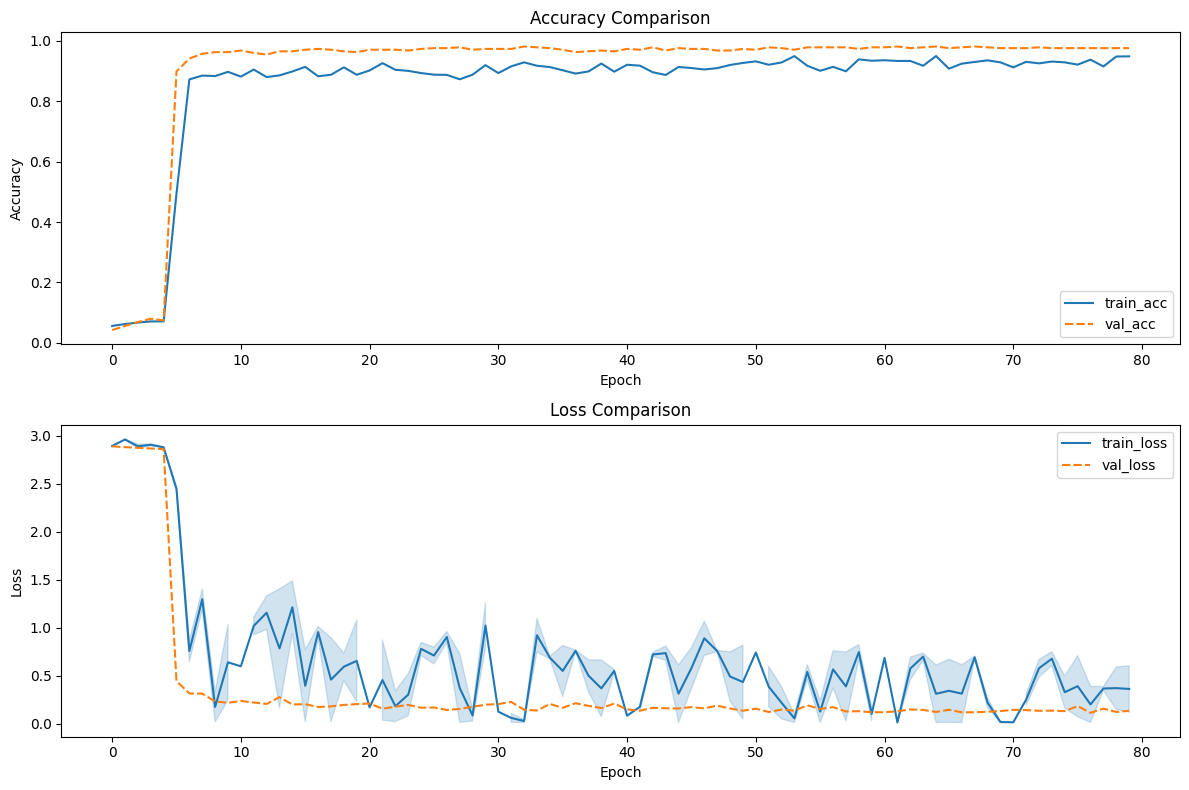

In [16]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
metrics.set_index("epoch", inplace=True)
accuracy_comparison = metrics[['train_acc', 'val_acc']]
loss_comparison = metrics[['train_loss', 'val_loss']]


fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot accuracy comparison
sns.lineplot(data=accuracy_comparison, ax=axes[0])
axes[0].set_title('Accuracy Comparison')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')

# Plot loss comparison
sns.lineplot(data=loss_comparison, ax=axes[1])
axes[1].set_title('Loss Comparison')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()


Plotting training and validation accuracy and training and validation loss during the training.

In [17]:
model_best_acc = CustomLightning.load_from_checkpoint("/content/drive/MyDrive/My projects/One Piece CNN/epoch=32-train_acc=0.929-val_acc=0.981.ckpt")
model_best_loss = CustomLightning.load_from_checkpoint("/content/drive/MyDrive/My projects/One Piece CNN/epoch=76-train_loss=0.798-val_loss=0.112.ckpt")


Recalling the best models saved through checkpoint ("highest validation accuracy" and "lowest validation loss").

In [18]:
test_results = trainer.test(model_best_acc, dataModule)


/usr/local/lib/python3.10/dist-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory /content/drive/MyDrive/My projects/One Piece CNN/lightning_logs/version_1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9813829660415649     │
│         test_loss         │    0.1446150541305542     │
└───────────────────────────┴───────────────────────────┘

In [19]:
test_results = trainer.test(model_best_loss, dataModule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9760637879371643     │
│         test_loss         │    0.11197753250598907    │
└───────────────────────────┴───────────────────────────┘

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Printing the scores of the models on the test data.
If it is needed to get the characted right at the first attempt, model_best_acc with a higher accuracy is robably better; if we need to get the highest number of correct answers considering the top x classes, probably model_best_loss is better.

In [26]:
def visualize_misclassified(model, dataloader, device, class_mapping):

    inverted_class_mapping = {value: key for key, value in class_mapping.items()}

    model = model.to(device)
    model.eval()
    misclassified_images = []
    true_labels = []
    predicted_labels = []

    # making the predictions
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            misclassified_mask = predicted != labels
            misclassified_images.extend(inputs[misclassified_mask])
            true_labels.extend(labels[misclassified_mask])
            predicted_labels.extend(predicted[misclassified_mask])

    num_misclassified = len(misclassified_images)

    matrix_width = 8

    num_rows = (num_misclassified + matrix_width - 1) // matrix_width

    fig, axes = plt.subplots(num_rows, matrix_width, figsize=(15,  2 * num_rows))

    # plotting misclassified images with their name label
    for i in range(num_misclassified):
        row_idx = i // matrix_width
        col_idx = i % matrix_width

        image = v2.functional.normalize(misclassified_images[i],
                             mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                             std=[1 / 0.229, 1 / 0.224, 1 / 0.225])
        image = 1 - image

        image = v2.ToPILImage()(image.cpu())

        if num_rows == 1:
            axes[col_idx].imshow(image)
            axes[col_idx].set_title(f"True: {inverted_class_mapping[true_labels[i].item()]} \n Pred: {inverted_class_mapping[predicted_labels[i].item()]}")
            axes[col_idx].axis("off")
        else:
            axes[row_idx, col_idx].imshow(image)
            axes[row_idx, col_idx].set_title(f"True: {inverted_class_mapping[true_labels[i].item()]} \n Pred: {inverted_class_mapping[predicted_labels[i].item()]}")
            axes[row_idx, col_idx].axis("off")

    plt.tight_layout()
    plt.show()


Creating a function to plot the misclassified images, together with their true and predicted label, to have an idea of what the model is having an hard time on.

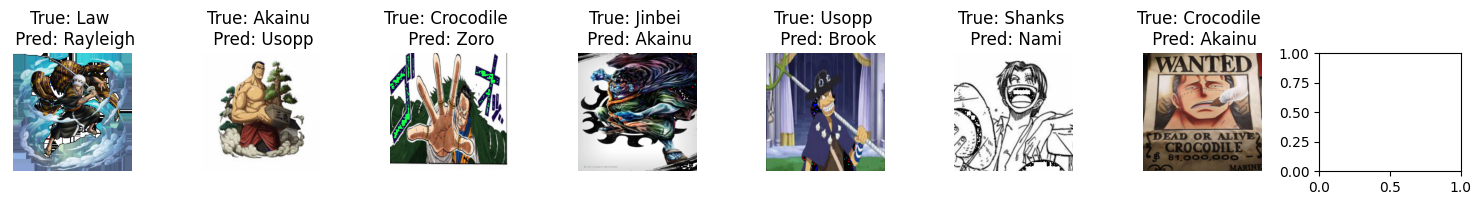

In [27]:
test_dataloader = dataModule.test_dataloader()
visualize_misclassified(model=model_best_acc, dataloader=test_dataloader, device="cuda", class_mapping=class_mapping)


Plotting the misclassified test images.

In [41]:
def conf_matrixx(model, dataloader, device, name_labels):
    all_preds = []
    all_labels = []

    model = model.to(device)
    model.eval()

    # making the preditions
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(F.softmax(outputs, dim=1), dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # plotting the confusion matrix
    plt.figure(figsize=(15, 9))
    sns.heatmap(cm, cmap="Blues", annot=True, xticklabels=name_labels, yticklabels=name_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


Creating a function to plot the confusion matrix of the results to have and idea of the characters the model is having an hard time with.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


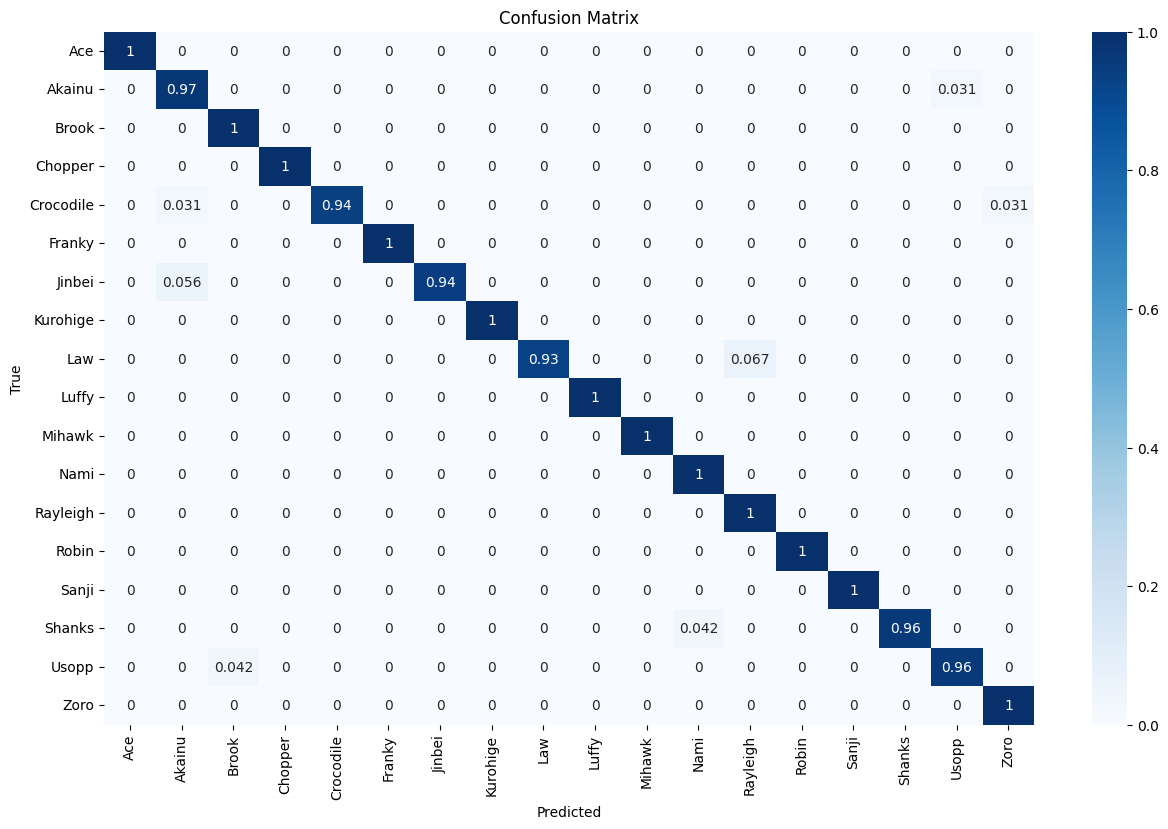

In [42]:
test_dataloader = dataModule.test_dataloader()
conf_matrixx(model=model_best_acc, dataloader=test_dataloader, device="cuda", name_labels=names)


Plotting the confusion matrix of the test results.